In [1]:
import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt

# Loading countries
We load the countries of the world and create STARE index values representing their cover. 

In [2]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
n_america = world[world.continent=='North America']

stare = starepandas.stare_from_gdf(n_america, level=7, force_ccw=True)
n_america = starepandas.STAREDataFrame(n_america, stare=stare)

# The trixels are just for visualization
n_america.set_trixels(inplace=True)
n_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare,trixels
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","[3035426148847714308, 3062447746611937284, 306...",(POLYGON ((-75.36119395309578 57.6315877704803...
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...","[3332663724254167043, 3071454945866678276, 307...",(POLYGON ((-90.00000034377467 35.2643901689254...
16,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169...","[3100869080932941831, 3100904265305030663, 310...",(POLYGON ((-72.49080671672886 19.1339374296424...
17,10734247,North America,Dominican Rep.,DOM,161900.0,"POLYGON ((-71.70830 18.04500, -71.68774 18.316...","[2506253192631681031, 2506323561375858695, 250...",(POLYGON ((-69.40758227230447 18.0684328436267...
19,329988,North America,Bahamas,BHS,9066.0,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...","[3126096275720634375, 3128875841115652103, 313...","(POLYGON ((-77.359038727403 26.6312970536891, ..."


<AxesSubplot:>

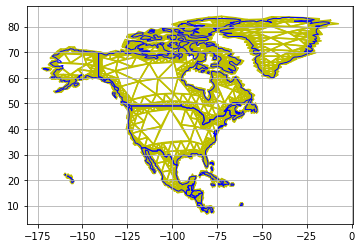

In [3]:
fig, ax = plt.subplots()
ax.grid(True)

n_america.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
n_america.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

# We are creating an catalogue dataframe

folder2catalogue() scans the path for granules, reads stare cover from the sidecar file as well as the timestamps from the metadata and creatse a catalogue dataframe

In [4]:
folder = 'data/sidecars/'
catalogue = starepandas.folder2catalogue(path=folder, 
                             granule_extension='hdf',
                             add_sf=True)
catalogue.head()

,begining,ending,geom,granule_name,sidecar_name,stare_cover
0,2019-12-02 00:00:00,2019-12-02 00:05:00,"POLYGON ((-15.93400 53.20178, -15.93275 53.292...",data/sidecars/MOD05_L2.A2019336.0000.061.20193...,data/sidecars/MOD05_L2.A2019336.0000.061.20193...,"[4298473764500464809, 4298458168380511209, 429..."
1,2019-12-02 00:05:00,2019-12-02 00:10:00,"POLYGON ((-15.14289 71.03160, -15.11598 71.121...",data/sidecars/MOD05_L2.A2019336.0005.061.20193...,data/sidecars/MOD05_L2.A2019336.0005.061.20193...,"[3652167195467210697, 3652159322601782569, 365..."


# Now we use the catalog to find all granules that intersect our ROI

## We can do this with geopandas SF based intersects method

In [5]:
geom = n_america[n_america.name=='Greenland'].geometry.iloc[0]

cover_intersects = catalogue.intersects(geom)
granule_subset = catalogue[cover_intersects].granule_name

granule_subset.head()

0    data/sidecars/MOD05_L2.A2019336.0000.061.20193...
1    data/sidecars/MOD05_L2.A2019336.0005.061.20193...
Name: granule_name, dtype: object

## We can do this with stare_intersects

In [6]:
roi_stare = n_america[n_america.name=='Greenland'].stare.iloc[0]

cover_intersects = catalogue.stare_intersects(roi_stare)
granule_subset = catalogue[cover_intersects].granule_name

msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 2 granules intersecting the ROI


0    data/sidecars/MOD05_L2.A2019336.0000.061.20193...
1    data/sidecars/MOD05_L2.A2019336.0005.061.20193...
Name: granule_name, dtype: object

# Finally, we extract the data from the pre-selected granules that intersects with our ROI

In [7]:
df = pandas.DataFrame()
for granule in granule_subset:
    g = starepandas.read_mod05(granule, sidecar=True)
    intersects = g.stare_intersects(roi_stare)
    msg = '{granule} has {n} intersecting points'.format(granule=granule,
                                                        n=sum(intersects))
    print(msg)
    df = df.append(g[intersects])

data/sidecars/MOD05_L2.A2019336.0000.061.2019336211522.hdf has 26756 intersecting points
data/sidecars/MOD05_L2.A2019336.0005.061.2019336211849.hdf has 46016 intersecting points


In [8]:
df.head()

,lat,lon,stare,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared
55278,59.822590,-43.944996,3630376560299884459,8.493986e+08,13256,-5505,2864,6766,-9999
55279,59.800552,-44.052574,3630376364319331947,8.493986e+08,13253,-5518,2910,6757,161
55280,59.778336,-44.160446,3630446998470491531,8.493986e+08,13249,-5532,2957,6748,166
55546,59.912483,-43.770641,3630379610335789163,8.493986e+08,13258,-5478,2771,6877,395
55547,59.891968,-43.872753,3630377324249826827,8.493986e+08,13255,-5491,2817,6867,-9999
